In [0]:
import pandas as pd
import numpy as np

In [0]:
data = pd.read_csv('https://raw.githubusercontent.com/sirajsandhu/Financial-Econometrics/master/CE_Europe.csv')
data.drop(0, inplace=True)

In [3]:
data = data.rename(columns={'Name': 'Date'})

data.fillna(method='bfill', inplace=True)
data.fillna(method='ffill', inplace=True)

data.columns[data.isna().any()]

Index(['#ERROR', 'ALCON AG - PRICE INDEX', '#ERROR.1'], dtype='object')

In [0]:
data.drop(columns=['#ERROR', 'ALCON AG - RETURN ON EQUITY - TOTAL (%)', 'ALCON AG - PRICE INDEX', 
                   'EDENRED S.A - MARKET CAPITALIZATION', '#ERROR.1', 'EDENRED S.A - PRICE INDEX'], inplace=True)

In [0]:
def Date_to_YearMo(date):
    month, year = date.split('/')[1:]
    
    if len(month) == 1:
        month = '0' + month
    
    return year + month

data['YEARMO'] = data['Date'].apply(lambda x: Date_to_YearMo(x)).astype(int)

In [6]:
suppl = pd.read_csv('https://raw.githubusercontent.com/sirajsandhu/Financial-Econometrics/master/Europe_3_Factors.csv')
data = pd.merge(left=data, right=suppl, left_on='YEARMO', right_on='YearMo')
data.head()

,Date,NESTLE SA - MARKET CAPITALIZATION,NESTLE SA - RETURN ON EQUITY - TOTAL (%),NESTLE SA - PRICE INDEX,NOVARTIS - MARKET CAPITALIZATION,NOVARTIS - RETURN ON EQUITY - TOTAL (%),NOVARTIS - PRICE INDEX,LVMH MOET HENNESSY - MARKET CAPITALIZATION,LVMH MOET HENNESSY - RETURN ON EQUITY - TOTAL (%),LVMH MOET HENNESSY - PRICE INDEX,ROCHE HOLDING AG - MARKET CAPITALIZATION,ROCHE HOLDING AG - RETURN ON EQUITY - TOTAL (%),ROCHE HOLDING AG - PRICE INDEX,3I GROUP PLC - MARKET CAPITALIZATION,3I GROUP PLC - RETURN ON EQUITY - TOTAL (%),3I GROUP PLC - PRICE INDEX,HSBC HOLDINGS PLC - MARKET CAPITALIZATION,HSBC HOLDINGS PLC - RETURN ON EQUITY - TOTAL (%),HSBC HOLDINGS PLC - PRICE INDEX,SAP SE - MARKET CAPITALIZATION,SAP SE - RETURN ON EQUITY - TOTAL (%),SAP - PRICE INDEX,ANHEUSER BUSCH IN - MARKET CAPITALIZATION,ANHEUSER BUSCH IN - RETURN ON EQUITY - TOTAL (%),ANHEUSER BUSCH IN - PRICE INDEX,L'OREAL SA - MARKET CAPITALIZATION,L'OREAL SA - RETURN ON EQUITY - TOTAL (%),L'OREAL SA - PRICE INDEX,BP PLC - MARKET CAPITALIZATION,BP PLC - RETURN ON EQUITY - TOTAL (%),BP PLC - PRICE INDEX,TOTAL SA - MARKET CAPITALIZATION,TOTAL SA - RETURN ON EQUITY - TOTAL (%),TOTAL SA - PRICE INDEX,ASTRAZENECA PLC - MARKET CAPITALIZATION,ASTRAZENECA PLC - RETURN ON EQUITY - TOTAL (%),ASTRAZENECA PLC - PRICE INDEX,ASML HOLDING NV - MARKET CAPITALIZATION,ASML HOLDING NV - RETURN ON EQUITY - TOTAL (%),ASML HOLDING NV - PRICE INDEX,...,AP MOELLER MAERSK - PRICE INDEX.1,ATLAS COPCO - MARKET CAPITALIZATION.1,ATLAS COPCO - RETURN ON EQUITY - TOTAL (%).1,ATLAS COPCO - PRICE INDEX.1,BAYER. MOTOREN WERKE - MARKET CAPITALIZATION.1,BAYER. MOTOREN WERKE - RETURN ON EQUITY - TOTAL (%).1,BAYER. MOTOREN WERKE - PRICE INDEX.1,CHOCO LINDT & SPRUEN - MARKET CAPITALIZATION.1,CHOCO LINDT & SPRUEN - RETURN ON EQUITY - TOTAL (%).1,CHOCO LINDT & SPRUEN - PRICE INDEX,EPIROC AB - MARKET CAPITALIZATION.1,EPIROC AB - RETURN ON EQUITY - TOTAL (%).1,EPIROC AB - PRICE INDEX.1,ESSITY AB - MARKET CAPITALIZATION,ESSITY AB - RETURN ON EQUITY - TOTAL (%),ESSITY AB - PRICE INDEX,HENKEL AG AND - MARKET CAPITALIZATION,HENKEL AG AND - RETURN ON EQUITY - TOTAL (%),HENKEL AG AND - PRICE INDEX,INDUSTRIVARDEN AB - MARKET CAPITALIZATION.1,INDUSTRIVARDEN AB - RETURN ON EQUITY - TOTAL (%).1,INDUSTRIVARDEN AB - PRICE INDEX.1,ROCHE HOLDING AG - MARKET CAPITALIZATION.1,ROCHE HOLDING AG - RETURN ON EQUITY - TOTAL (%).1,ROCHE HOLDING AG - PRICE INDEX.1,SCHINDLER HOLDING AG - MARKET CAPITALIZATION.1,SCHINDLER HOLDING AG - RETURN ON EQUITY - TOTAL (%).1,SCHINDLER HOLDING AG - PRICE INDEX.1,TELECOM ITALIA - MARKET CAPITALIZATION.1,TELECOM ITALIA - RETURN ON EQUITY - TOTAL (%).1,TELECOM ITALIA - PRICE INDEX.1,THE SWATCH GROUP - MARKET CAPITALIZATION.1,THE SWATCH GROUP - RETURN ON EQUITY - TOTAL (%).1,THE SWATCH GROUP - PRICE INDEX.1,YEARMO,YearMo,Mkt-RF,SMB,HML,RF
0,17/1/2013,208279321,16.21,2727.8,172737203,13.07,2241.3,66353271,13.44,8108.9,211577029,66.04,1200,3069640,6.58,145.2,124729967,9.56,738.9,74379988,22.05,11690.3,123776508,31.9,321.6,76593698,13.58,12027.5,90966141,19.83,4322.7,101014689,11.74,2169.2,44937545,11.4,498.1,29995593,18.63,3385.2,...,5961.8,216376484,32.73,2234.2,55926050,16.11,744.3,10900465,14,745.6,101759853,21.11,99.9,162732755,14.83,98.2,36613993,16.36,1049.6,47913466,22.55,468.5,211577029,66.04,1128.1,14682001,16.44,5331.7,13901563,-3.7,44.4,32020898,21.27,1822.2,201301,201301,6.20,0.43,4.24,0.0
1,17/2/2013,208279321,16.21,2719.2,172737203,13.07,2321.2,66353271,13.44,7584.3,211577029,66.04,1218.4,3069640,6.58,177.6,124729967,9.56,776.6,74379988,22.05,12058.2,123776508,31.9,337.8,76593698,13.58,12277.5,90966141,19.83,4201.7,101014689,11.74,2037.6,44937545,11.4,476.3,29995593,18.63,3592.3,...,5787.3,216376484,32.73,2284.9,55926050,16.11,735.7,10900465,14,779.8,101759853,21.11,99.9,162732755,14.83,98.2,36613993,16.36,1098.7,47913466,22.55,502.1,211577029,66.04,1144.7,14682001,16.44,5528,13901563,-3.7,37.2,32020898,21.27,1873.9,201302,201302,-2.49,2.09,-3.44,0.0
2,17/3/2013,208279321,16.21,2958,17

In [0]:
N = (data.shape[1] - 7)//3

mc_indices = [int(i*3 + 1) for i in range(0, N)]
re_indices = [int(i*3 + 2) for i in range(0, N)]
pr_indices = [int(i*3 + 3) for i in range(0, N)]

mkt_cp = data.iloc[:, mc_indices].astype(int).drop(0)
ret_eq = data.iloc[:, re_indices].astype(float).drop(0)
prices = data.iloc[:, pr_indices].astype(float)

prices = np.log(prices/prices.shift(1))
prices.drop(0, inplace=True)

mkt_cp.rename(columns = dict(zip(mkt_cp.columns, [col.split('-')[0].strip() for col in mkt_cp.columns])), inplace=True)
ret_eq.rename(columns = dict(zip(ret_eq.columns, [col.split('-')[0].strip() for col in ret_eq.columns])), inplace=True)
prices.rename(columns = dict(zip(prices.columns, [col.split('-')[0].strip() for col in prices.columns])), inplace=True)

In [8]:
smb = []
hml = []
mom = []

for i in range(0, prices.shape[0]):
    all_sorted = mkt_cp.iloc[i].sort_values()
    small_caps = all_sorted[:N//2].index
    big_caps = all_sorted[N//2:].index

    all_sorted = ret_eq.iloc[i].sort_values()
    growth = all_sorted[:int(N*0.3)].index
    neutral = all_sorted[int(N*0.3): int(N*0.7)].index
    value = all_sorted[int(N*0.7):].index

    sg = prices.iloc[i].loc[small_caps.intersection(growth)].mean()
    sn = prices.iloc[i].loc[small_caps.intersection(neutral)].mean()
    sv = prices.iloc[i].loc[small_caps.intersection(value)].mean()

    bg = prices.iloc[i].loc[big_caps.intersection(growth)].mean()
    bn = prices.iloc[i].loc[big_caps.intersection(neutral)].mean()
    bv = prices.iloc[i].loc[big_caps.intersection(value)].mean()

    if i >= 12:
        all_sorted = prices.iloc[i-12: i-1].mean().sort_values()
        low = all_sorted[:N//2].index
        high = all_sorted[N//2:].index

        sl = prices.iloc[i].loc[small_caps.intersection(low)].mean()
        sh = prices.iloc[i].loc[small_caps.intersection(high)].mean()

        bl = prices.iloc[i].loc[big_caps.intersection(low)].mean()
        bh = prices.iloc[i].loc[big_caps.intersection(high)].mean()

        mom.append(float((sh + bh)/2 - (sl + bl)/2))
    else:
        mom.append(float(0))

    smb.append(float((sv + sn + sg)/3 - (bv + bn + bg)/3))
    hml.append(float((sv + bv)/2 - (sg + bg)/2))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:


In [9]:
prices.columns

Index(['NESTLE SA', 'NOVARTIS', 'LVMH MOET HENNESSY', 'ROCHE HOLDING AG',
       '3I GROUP PLC', 'HSBC HOLDINGS PLC', 'SAP', 'ANHEUSER BUSCH IN',
       'L'OREAL SA', 'BP PLC',
       ...
       'BAYER. MOTOREN WERKE', 'CHOCO LINDT & SPRUEN', 'EPIROC AB',
       'ESSITY AB', 'HENKEL AG AND', 'INDUSTRIVARDEN AB', 'ROCHE HOLDING AG',
       'SCHINDLER HOLDING AG', 'TELECOM ITALIA', 'THE SWATCH GROUP'],
      dtype='object', length=360)

In [10]:
import statsmodels.api as sm

prices = prices.loc[:, ~prices.columns.duplicated()]
stocks = prices.columns

prices['SMB'] = smb
prices['HML'] = hml
prices['Rm'] = data['Mkt-RF'][1:]

alphas = []
betas_Rm = []
betas_SMB = []
betas_HML = []

for stock in stocks:
    X = prices[['Rm', 'SMB', 'HML']]
    Y = prices[stock] - data['RF'][1:]

    X = sm.add_constant(X)

    model = sm.OLS(Y, X).fit()
    
    print('\n\nRegression for {}'.format(stock))
    print(model.summary())

    alphas.append(model.params[0])
    betas_Rm.append(model.params[1])
    betas_SMB.append(model.params[2])
    betas_HML.append(model.params[3])

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Streaming output truncated to the last 5000 lines.
Df Residuals:                      67   BIC:                            -165.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0378      0.009     -4.358      0.000      -0.055      -0.020
Rm             0.0078      0.002      3.319      0.001       0.003       0.013
SMB            0.9945      0.708      1.405      0.165      -0.418       2.407
HML           -0.2912      0.370     -0.788      0.434      -1.029       0.447
Omnibus:                        3.105   Durbin-Watson:                   0.651
Prob(Omnibus):                  0.212   Jarque-Bera (JB):                2.848
Skew:                          -0.488   Prob(JB):                        0.241
K

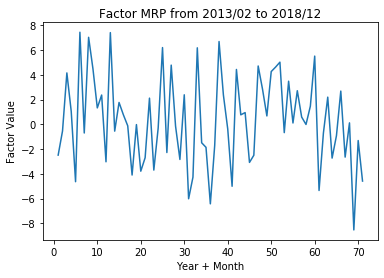

In [11]:
import matplotlib.pyplot as plt

plt.plot(prices['Rm'])
plt.xlabel('Year + Month')
plt.ylabel('Factor Value')
plt.title('Factor MRP from 2013/02 to 2018/12')
plt.show()

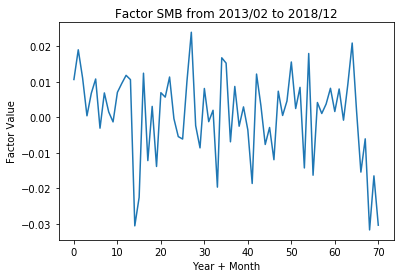

In [12]:
plt.plot(smb)
plt.xlabel('Year + Month')
plt.ylabel('Factor Value')
plt.title('Factor SMB from 2013/02 to 2018/12')
plt.show()

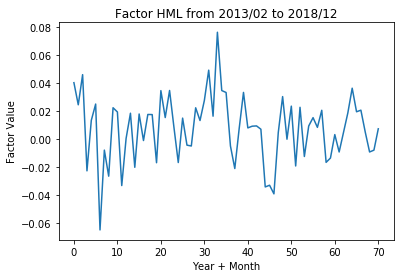

In [13]:
plt.plot(hml)
plt.xlabel('Year + Month')
plt.ylabel('Factor Value')
plt.title('Factor HML from 2013/02 to 2018/12')
plt.show()

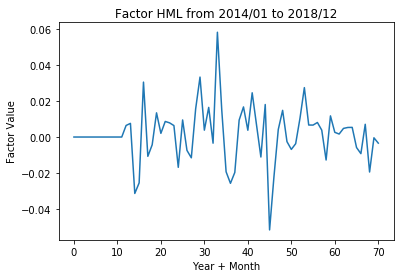

In [14]:
plt.plot(mom)
plt.xlabel('Year + Month')
plt.ylabel('Factor Value')
plt.title('Factor HML from 2014/01 to 2018/12')
plt.show()

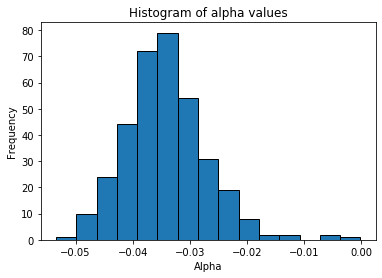

In [15]:
plt.hist(alphas, bins=15, edgecolor = 'black')
plt.xlabel('Alpha')
plt.ylabel('Frequency')
plt.title('Histogram of alpha values')
plt.show()

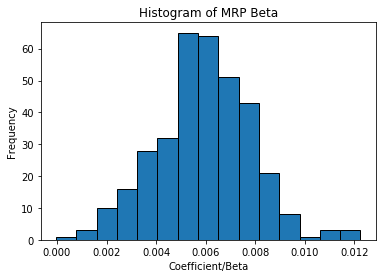

In [29]:
plt.hist(betas_Rm, bins=15, edgecolor = 'black')
plt.xlabel('Coefficient/Beta')
plt.ylabel('Frequency')
plt.title('Histogram of MRP Beta')
plt.show()

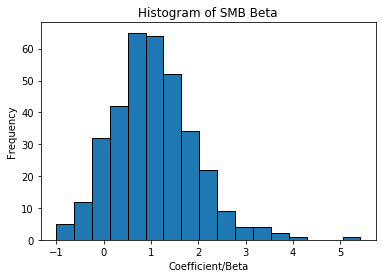

In [26]:
plt.hist(betas_SMB, bins=17, edgecolor = 'black')
plt.xlabel('Coefficient/Beta')
plt.ylabel('Frequency')
plt.title('Histogram of SMB Beta')
plt.show()

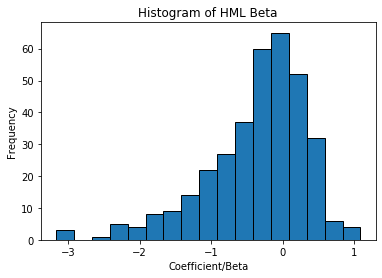

In [27]:
plt.hist(betas_HML, bins=17, edgecolor = 'black')
plt.xlabel('Coefficient/Beta')
plt.ylabel('Frequency')
plt.title('Histogram of HML Beta')
plt.show()